In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import torch
import zipfile
import collections
import torchvision
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from google.colab import drive
drive.mount('/content/gdrive')

files = zipfile.ZipFile('/content/gdrive/MyDrive/brats_slices_2.zip', 'r')
files.extractall('/content')
data_folder = Path('/content/brats_slices_2/')
df = pd.read_csv('/content/gdrive/MyDrive/meta.csv', index_col=0)

Mounted at /content/gdrive


In [33]:
from VGG16 import VGG16

def normalize(image):
    if image.max() > 1e-6:
        image /= image.max()
    return image
    
def to_tensor(image):
    image = image.reshape(1, 1, image.shape[0], image.shape[1])
    return torch.from_numpy(image)


device = ('cuda' if torch.cuda.is_available() else 'cpu')    
model = VGG16().to(device)
model.load_state_dict(torch.load('/content/gdrive/MyDrive/model_20.pt'))
model.eval()

def probability_map(path, box_size=5):
    base_image = np.load(path + '.npy', allow_pickle=True)
    mask = np.load(path + '_mask.npy', allow_pickle=True)
    base_image = to_tensor(normalize(base_image))
    output = model(base_image.to(device).float())
    baseline_prob = torch.sigmoid(output).item()
    print('Baseline probability:', baseline_prob)
    image = np.load(path + '.npy', allow_pickle=True)
    outputs = []

    for i in tqdm(range(image.shape[0] // box_size)):
        for j in range(image.shape[1] // box_size):
            img_box = image.copy()
            img_box[(box_size * i):(box_size * (i+1)), (box_size*j):(box_size*(j+1))] = 0
            img_box = to_tensor(normalize(img_box))
            output = model(img_box.to(device).float())
            outputs.append(output.item())
    outputs = torch.Tensor(outputs)
    probs = torch.sigmoid(outputs)
    plt.rcParams["figure.figsize"] = (10, 5)
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
    ax1.imshow(image, cmap='gray')
    ax2.imshow(mask, cmap='gray')
    n = int(np.sqrt(probs.shape).item())
    ax3.imshow((probs).reshape(n, n), cmap='magma')
    ax1.set_title('Image')
    ax2.set_title('Mask')
    ax3.set_title('Probability map')
    plt.show;

Baseline probability: 0.9999997615814209


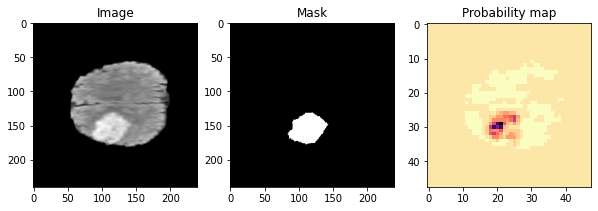

In [34]:
path = '/content/brats_slices_2/BraTS20_Training_266/100'
probability_map(path=path, box_size=5)

Baseline probability: 0.9999709129333496


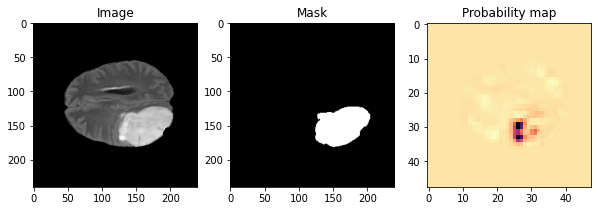

In [35]:
path = '/content/brats_slices_2/BraTS20_Training_333/100'
probability_map(path=path, box_size=5)

Baseline probability: 0.9997022747993469


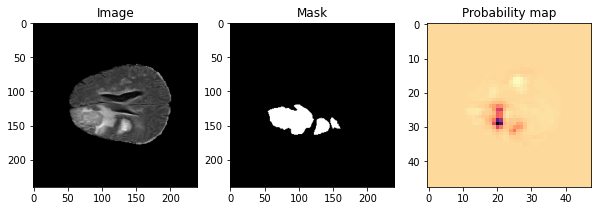

In [36]:
path = '/content/brats_slices_2/BraTS20_Training_106/100'
probability_map(path=path, box_size=5)

Baseline probability: 0.995686411857605


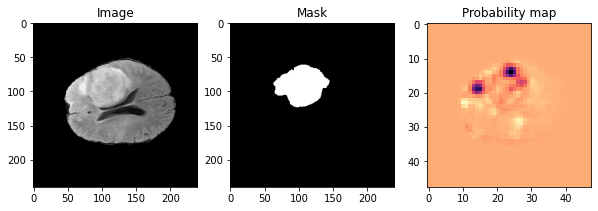

In [38]:
path = '/content/brats_slices_2/BraTS20_Training_360/100'
probability_map(path=path, box_size=5)